In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [5]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_Xception"

In [6]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [7]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [8]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [11]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [12]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


input_tensor = Input(shape = input_shape)  
model = Xception(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [13]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [14]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [15]:
# bottleneck_final_model.summary()

In [16]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [17]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [18]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [19]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 2s - loss: 0.4550 - acc: 0.7835 - val_loss: 0.3277 - val_acc: 0.8652
Epoch 2/1000
 - 1s - loss: 0.3049 - acc: 0.8730 - val_loss: 0.2597 - val_acc: 0.8975
Epoch 3/1000
 - 1s - loss: 0.2396 - acc: 0.9085 - val_loss: 0.2181 - val_acc: 0.9143
Epoch 4/1000
 - 1s - loss: 0.1956 - acc: 0.9283 - val_loss: 0.1887 - val_acc: 0.9287
Epoch 5/1000
 - 1s - loss: 0.1647 - acc: 0.9405 - val_loss: 0.1658 - val_acc: 0.9375
Epoch 6/1000
 - 1s - loss: 0.1417 - acc: 0.9514 - val_loss: 0.1525 - val_acc: 0.9410
Epoch 7/1000
 - 1s - loss: 0.1204 - acc: 0.9609 - val_loss: 0.1455 - val_acc: 0.9445
Epoch 8/1000
 - 1s - loss: 0.1080 - acc: 0.9658 - val_loss: 0.1271 - val_acc: 0.9522
Epoch 9/1000
 - 1s - loss: 0.0947 - acc: 0.9711 - val_loss: 0.1201 - val_acc: 0.9554
Epoch 10/1000
 - 1s - loss: 0.0827 - acc: 0.9739 - val_loss: 0.1138 - val_acc: 0.9593
Epoch 11/1000
 - 1s - loss: 0.0722 - acc: 0.9789 - val_loss: 0.1077 - val_acc: 0.9589
Epoch 12/1000
 

Epoch 95/1000
 - 1s - loss: 1.1946e-04 - acc: 1.0000 - val_loss: 0.1140 - val_acc: 0.9747
Epoch 96/1000
 - 1s - loss: 2.0576e-04 - acc: 1.0000 - val_loss: 0.1168 - val_acc: 0.9751
Epoch 97/1000
 - 1s - loss: 7.2140e-05 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9765
Epoch 98/1000
 - 1s - loss: 9.2299e-05 - acc: 1.0000 - val_loss: 0.1131 - val_acc: 0.9775
Epoch 99/1000
 - 1s - loss: 7.1214e-05 - acc: 1.0000 - val_loss: 0.1150 - val_acc: 0.9782
Epoch 100/1000
 - 1s - loss: 1.1782e-04 - acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.9765
Epoch 101/1000
 - 1s - loss: 7.9050e-05 - acc: 1.0000 - val_loss: 0.1254 - val_acc: 0.9758
Epoch 102/1000
 - 1s - loss: 7.7769e-05 - acc: 1.0000 - val_loss: 0.1240 - val_acc: 0.9775
Epoch 103/1000
 - 1s - loss: 4.2791e-05 - acc: 1.0000 - val_loss: 0.1199 - val_acc: 0.9775
Epoch 104/1000
 - 1s - loss: 4.3302e-05 - acc: 1.0000 - val_loss: 0.1233 - val_acc: 0.9768
Epoch 105/1000
 - 1s - loss: 3.4243e-05 - acc: 1.0000 - val_loss: 0.1218 - val_acc: 0.9765
Epoc

 - 1s - loss: 2.2327e-06 - acc: 1.0000 - val_loss: 0.1404 - val_acc: 0.9761
Epoch 186/1000
 - 1s - loss: 1.7366e-06 - acc: 1.0000 - val_loss: 0.1391 - val_acc: 0.9782
Epoch 187/1000
 - 1s - loss: 9.8886e-07 - acc: 1.0000 - val_loss: 0.1365 - val_acc: 0.9775
Epoch 188/1000
 - 1s - loss: 1.1370e-06 - acc: 1.0000 - val_loss: 0.1388 - val_acc: 0.9789
Epoch 189/1000
 - 1s - loss: 1.3525e-04 - acc: 0.9999 - val_loss: 0.1402 - val_acc: 0.9782
Epoch 190/1000
 - 1s - loss: 3.4987e-06 - acc: 1.0000 - val_loss: 0.1463 - val_acc: 0.9761
Epoch 191/1000
 - 1s - loss: 3.5661e-06 - acc: 1.0000 - val_loss: 0.1424 - val_acc: 0.9779
Epoch 192/1000
 - 1s - loss: 4.4537e-07 - acc: 1.0000 - val_loss: 0.1418 - val_acc: 0.9779
Epoch 193/1000
 - 1s - loss: 1.5329e-06 - acc: 1.0000 - val_loss: 0.1432 - val_acc: 0.9779
Epoch 194/1000
 - 1s - loss: 6.8411e-07 - acc: 1.0000 - val_loss: 0.1485 - val_acc: 0.9779
Epoch 195/1000
 - 1s - loss: 8.7316e-07 - acc: 1.0000 - val_loss: 0.1420 - val_acc: 0.9775
Epoch 196/1000

Epoch 276/1000
 - 1s - loss: 6.6523e-07 - acc: 1.0000 - val_loss: 0.1481 - val_acc: 0.9793
Epoch 277/1000
 - 1s - loss: 1.8470e-07 - acc: 1.0000 - val_loss: 0.1477 - val_acc: 0.9803
Epoch 278/1000
 - 1s - loss: 2.0861e-07 - acc: 1.0000 - val_loss: 0.1501 - val_acc: 0.9793
Epoch 279/1000
 - 1s - loss: 1.7853e-07 - acc: 1.0000 - val_loss: 0.1544 - val_acc: 0.9786
Epoch 280/1000
 - 1s - loss: 2.1438e-07 - acc: 1.0000 - val_loss: 0.1462 - val_acc: 0.9793
Epoch 281/1000
 - 1s - loss: 2.3821e-07 - acc: 1.0000 - val_loss: 0.1508 - val_acc: 0.9786
Epoch 282/1000
 - 1s - loss: 1.9631e-07 - acc: 1.0000 - val_loss: 0.1508 - val_acc: 0.9789
Epoch 283/1000
 - 1s - loss: 2.1156e-07 - acc: 1.0000 - val_loss: 0.1530 - val_acc: 0.9793
Epoch 284/1000
 - 1s - loss: 2.9216e-07 - acc: 1.0000 - val_loss: 0.1536 - val_acc: 0.9779
Epoch 285/1000
 - 1s - loss: 2.8568e-07 - acc: 1.0000 - val_loss: 0.1455 - val_acc: 0.9782
Epoch 286/1000
 - 1s - loss: 2.3373e-07 - acc: 1.0000 - val_loss: 0.1501 - val_acc: 0.9782

 - 1s - loss: 1.5471e-07 - acc: 1.0000 - val_loss: 0.1520 - val_acc: 0.9782
Epoch 367/1000
 - 1s - loss: 1.4102e-07 - acc: 1.0000 - val_loss: 0.1567 - val_acc: 0.9782
Epoch 368/1000
 - 1s - loss: 1.8159e-07 - acc: 1.0000 - val_loss: 0.1539 - val_acc: 0.9800
Epoch 369/1000
 - 1s - loss: 1.5545e-06 - acc: 1.0000 - val_loss: 0.1522 - val_acc: 0.9775
Epoch 370/1000
 - 1s - loss: 1.4595e-07 - acc: 1.0000 - val_loss: 0.1515 - val_acc: 0.9796
Epoch 371/1000
 - 1s - loss: 1.6342e-07 - acc: 1.0000 - val_loss: 0.1530 - val_acc: 0.9779
Epoch 372/1000
 - 1s - loss: 1.6397e-07 - acc: 1.0000 - val_loss: 0.1523 - val_acc: 0.9796
Epoch 373/1000
 - 1s - loss: 2.2397e-07 - acc: 1.0000 - val_loss: 0.1576 - val_acc: 0.9782
Epoch 374/1000
 - 1s - loss: 1.5987e-07 - acc: 1.0000 - val_loss: 0.1538 - val_acc: 0.9779
Epoch 375/1000
 - 1s - loss: 3.5448e-07 - acc: 1.0000 - val_loss: 0.1544 - val_acc: 0.9789
Epoch 376/1000
 - 1s - loss: 1.3778e-07 - acc: 1.0000 - val_loss: 0.1499 - val_acc: 0.9779
Epoch 377/1000

Epoch 457/1000
 - 1s - loss: 1.2908e-07 - acc: 1.0000 - val_loss: 0.1512 - val_acc: 0.9793
Epoch 458/1000
 - 1s - loss: 1.3668e-07 - acc: 1.0000 - val_loss: 0.1488 - val_acc: 0.9793
Epoch 459/1000
 - 1s - loss: 1.5897e-07 - acc: 1.0000 - val_loss: 0.1527 - val_acc: 0.9800
Epoch 460/1000
 - 1s - loss: 1.3024e-07 - acc: 1.0000 - val_loss: 0.1510 - val_acc: 0.9800
Epoch 461/1000
 - 1s - loss: 1.3100e-07 - acc: 1.0000 - val_loss: 0.1499 - val_acc: 0.9800
Epoch 462/1000
 - 1s - loss: 1.2737e-07 - acc: 1.0000 - val_loss: 0.1492 - val_acc: 0.9796
Epoch 463/1000
 - 1s - loss: 1.2810e-07 - acc: 1.0000 - val_loss: 0.1541 - val_acc: 0.9789
Epoch 464/1000
 - 1s - loss: 3.5985e-07 - acc: 1.0000 - val_loss: 0.1536 - val_acc: 0.9789
Epoch 465/1000
 - 1s - loss: 1.4585e-07 - acc: 1.0000 - val_loss: 0.1538 - val_acc: 0.9786
Epoch 466/1000
 - 1s - loss: 3.6303e-07 - acc: 1.0000 - val_loss: 0.1573 - val_acc: 0.9796
Epoch 467/1000
 - 1s - loss: 1.3706e-07 - acc: 1.0000 - val_loss: 0.1572 - val_acc: 0.9796

 - 1s - loss: 1.4500e-07 - acc: 1.0000 - val_loss: 0.1557 - val_acc: 0.9796
Epoch 548/1000
 - 1s - loss: 1.2702e-07 - acc: 1.0000 - val_loss: 0.1535 - val_acc: 0.9789
Epoch 549/1000
 - 1s - loss: 4.8005e-07 - acc: 1.0000 - val_loss: 0.1476 - val_acc: 0.9789
Epoch 550/1000
 - 1s - loss: 2.3638e-07 - acc: 1.0000 - val_loss: 0.1497 - val_acc: 0.9789
Epoch 551/1000
 - 1s - loss: 1.3211e-07 - acc: 1.0000 - val_loss: 0.1513 - val_acc: 0.9796
Epoch 552/1000
 - 1s - loss: 1.6694e-07 - acc: 1.0000 - val_loss: 0.1510 - val_acc: 0.9782
Epoch 553/1000
 - 1s - loss: 1.3544e-07 - acc: 1.0000 - val_loss: 0.1573 - val_acc: 0.9800
Epoch 554/1000
 - 1s - loss: 1.0499e-05 - acc: 1.0000 - val_loss: 0.1496 - val_acc: 0.9803
Epoch 555/1000
 - 1s - loss: 1.2884e-07 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.9786
Epoch 556/1000
 - 1s - loss: 1.2902e-07 - acc: 1.0000 - val_loss: 0.1503 - val_acc: 0.9793
Epoch 557/1000
 - 1s - loss: 1.5351e-06 - acc: 1.0000 - val_loss: 0.1552 - val_acc: 0.9793
Epoch 558/1000

Epoch 638/1000
 - 1s - loss: 1.6181e-07 - acc: 1.0000 - val_loss: 0.1517 - val_acc: 0.9796
Epoch 639/1000
 - 1s - loss: 2.0951e-07 - acc: 1.0000 - val_loss: 0.1570 - val_acc: 0.9796
Epoch 640/1000
 - 1s - loss: 1.3129e-07 - acc: 1.0000 - val_loss: 0.1579 - val_acc: 0.9789
Epoch 641/1000
 - 1s - loss: 1.2642e-07 - acc: 1.0000 - val_loss: 0.1583 - val_acc: 0.9789
Epoch 642/1000
 - 1s - loss: 1.2646e-07 - acc: 1.0000 - val_loss: 0.1558 - val_acc: 0.9782
Epoch 643/1000
 - 1s - loss: 1.7369e-07 - acc: 1.0000 - val_loss: 0.1579 - val_acc: 0.9786
Epoch 644/1000
 - 1s - loss: 1.3620e-07 - acc: 1.0000 - val_loss: 0.1574 - val_acc: 0.9789
Epoch 645/1000
 - 1s - loss: 1.6375e-07 - acc: 1.0000 - val_loss: 0.1603 - val_acc: 0.9786
Epoch 646/1000
 - 1s - loss: 1.4451e-07 - acc: 1.0000 - val_loss: 0.1576 - val_acc: 0.9793
Epoch 647/1000
 - 1s - loss: 1.2140e-07 - acc: 1.0000 - val_loss: 0.1567 - val_acc: 0.9789
Epoch 648/1000
 - 1s - loss: 1.2564e-07 - acc: 1.0000 - val_loss: 0.1587 - val_acc: 0.9803

 - 1s - loss: 1.4683e-07 - acc: 1.0000 - val_loss: 0.1544 - val_acc: 0.9793
Epoch 729/1000
 - 1s - loss: 1.2916e-07 - acc: 1.0000 - val_loss: 0.1575 - val_acc: 0.9800
Epoch 730/1000
 - 1s - loss: 1.2442e-07 - acc: 1.0000 - val_loss: 0.1541 - val_acc: 0.9796
Epoch 731/1000
 - 1s - loss: 1.2449e-07 - acc: 1.0000 - val_loss: 0.1559 - val_acc: 0.9786
Epoch 732/1000
 - 1s - loss: 1.4032e-07 - acc: 1.0000 - val_loss: 0.1604 - val_acc: 0.9803
Epoch 733/1000
 - 1s - loss: 1.2695e-07 - acc: 1.0000 - val_loss: 0.1585 - val_acc: 0.9803
Epoch 734/1000
 - 1s - loss: 1.9943e-07 - acc: 1.0000 - val_loss: 0.1629 - val_acc: 0.9789
Epoch 735/1000
 - 1s - loss: 1.2434e-07 - acc: 1.0000 - val_loss: 0.1615 - val_acc: 0.9793
Epoch 736/1000
 - 1s - loss: 1.2970e-07 - acc: 1.0000 - val_loss: 0.1568 - val_acc: 0.9793
Epoch 737/1000
 - 1s - loss: 1.2118e-07 - acc: 1.0000 - val_loss: 0.1571 - val_acc: 0.9793
Epoch 738/1000
 - 1s - loss: 1.7871e-07 - acc: 1.0000 - val_loss: 0.1568 - val_acc: 0.9775
Epoch 739/1000

Epoch 819/1000
 - 1s - loss: 1.2830e-07 - acc: 1.0000 - val_loss: 0.1515 - val_acc: 0.9800
Epoch 820/1000
 - 1s - loss: 1.2394e-07 - acc: 1.0000 - val_loss: 0.1508 - val_acc: 0.9800
Epoch 821/1000
 - 1s - loss: 1.2287e-07 - acc: 1.0000 - val_loss: 0.1531 - val_acc: 0.9786
Epoch 822/1000
 - 1s - loss: 1.2961e-07 - acc: 1.0000 - val_loss: 0.1522 - val_acc: 0.9796
Epoch 823/1000
 - 1s - loss: 1.4513e-07 - acc: 1.0000 - val_loss: 0.1520 - val_acc: 0.9796
Epoch 824/1000
 - 1s - loss: 2.1735e-07 - acc: 1.0000 - val_loss: 0.1525 - val_acc: 0.9800
Epoch 825/1000
 - 1s - loss: 1.2237e-07 - acc: 1.0000 - val_loss: 0.1531 - val_acc: 0.9796
Epoch 826/1000
 - 1s - loss: 1.2319e-07 - acc: 1.0000 - val_loss: 0.1536 - val_acc: 0.9796
Epoch 827/1000
 - 1s - loss: 1.2359e-07 - acc: 1.0000 - val_loss: 0.1580 - val_acc: 0.9793
Epoch 828/1000
 - 1s - loss: 1.2103e-07 - acc: 1.0000 - val_loss: 0.1556 - val_acc: 0.9803
Epoch 829/1000
 - 1s - loss: 1.2370e-07 - acc: 1.0000 - val_loss: 0.1553 - val_acc: 0.9796

 - 1s - loss: 1.5026e-07 - acc: 1.0000 - val_loss: 0.1555 - val_acc: 0.9796
Epoch 910/1000
 - 1s - loss: 1.7476e-07 - acc: 1.0000 - val_loss: 0.1572 - val_acc: 0.9793
Epoch 911/1000
 - 1s - loss: 1.2139e-07 - acc: 1.0000 - val_loss: 0.1558 - val_acc: 0.9789
Epoch 912/1000
 - 1s - loss: 2.2529e-07 - acc: 1.0000 - val_loss: 0.1559 - val_acc: 0.9793
Epoch 913/1000
 - 1s - loss: 1.2429e-07 - acc: 1.0000 - val_loss: 0.1539 - val_acc: 0.9793
Epoch 914/1000
 - 1s - loss: 1.2018e-07 - acc: 1.0000 - val_loss: 0.1546 - val_acc: 0.9789
Epoch 915/1000
 - 1s - loss: 1.2100e-07 - acc: 1.0000 - val_loss: 0.1572 - val_acc: 0.9793
Epoch 916/1000
 - 1s - loss: 4.7596e-07 - acc: 1.0000 - val_loss: 0.1596 - val_acc: 0.9796
Epoch 917/1000
 - 1s - loss: 1.3355e-07 - acc: 1.0000 - val_loss: 0.1594 - val_acc: 0.9800
Epoch 918/1000
 - 1s - loss: 1.3265e-07 - acc: 1.0000 - val_loss: 0.1532 - val_acc: 0.9789
Epoch 919/1000
 - 1s - loss: 1.2245e-07 - acc: 1.0000 - val_loss: 0.1535 - val_acc: 0.9786
Epoch 920/1000

Epoch 1000/1000
 - 1s - loss: 1.2213e-07 - acc: 1.0000 - val_loss: 0.1580 - val_acc: 0.9793


In [20]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.7887323943661971


Confusion Matrix
[[29  7]
 [ 8 27]]


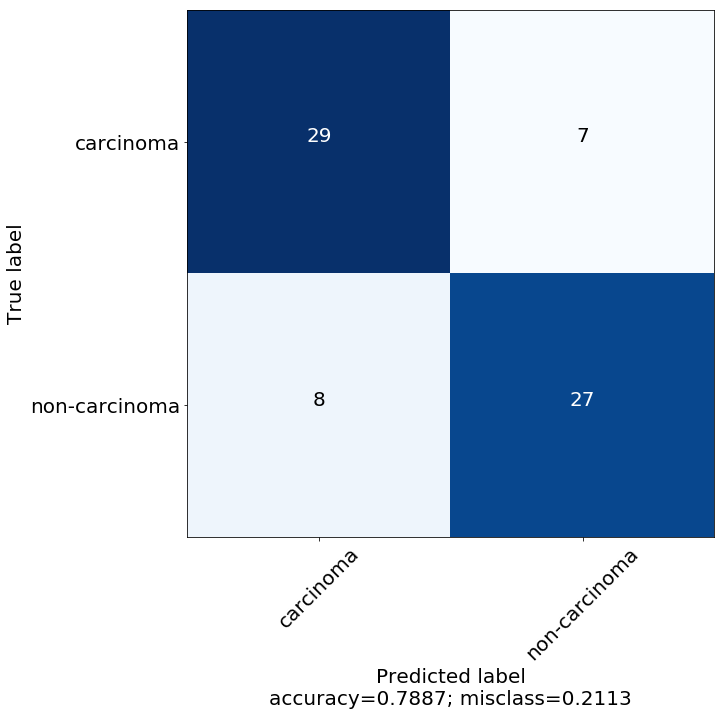

In [21]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[29  7]
 [ 8 27]]
               precision    recall  f1-score   support

    carcinoma       0.78      0.81      0.79        36
non-carcinoma       0.79      0.77      0.78        35

  avg / total       0.79      0.79      0.79        71



In [23]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  78.37837837837837
Specificity :  79.41176470588235


In [24]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.7889507154213036


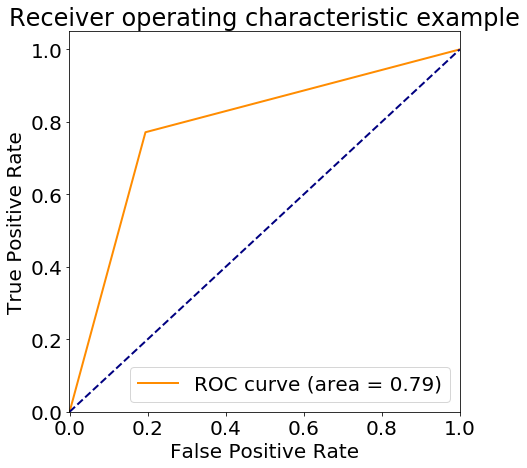

In [25]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [26]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 42us/step


In [27]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

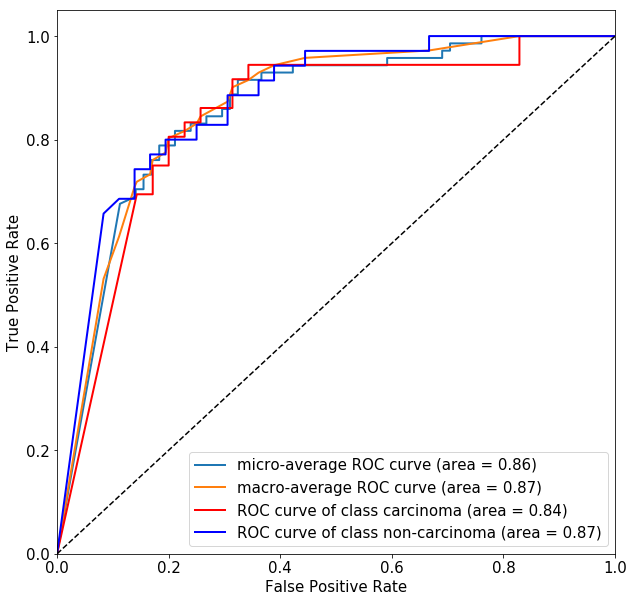

In [29]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [30]:
tn, fp, fn, tp = cm.ravel()

In [31]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.7887323943661971
Precision: 0.7941176470588235
Recall: 0.7714285714285715
tp: 27
fp: 7
tn: 29
fn: 8


In [32]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.782608695652174


In [33]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.782608695652174


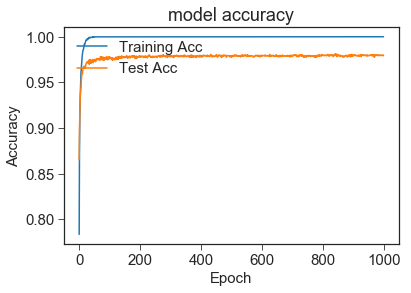

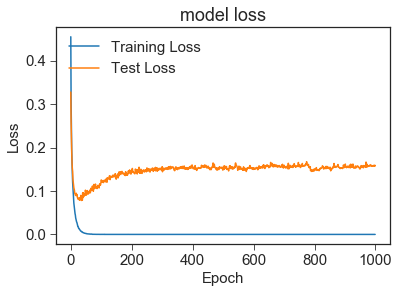

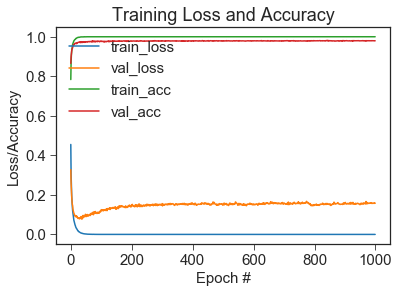

In [34]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")